### 4 Point Transform: to get perspective

Source: https://pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

In [1]:
import numpy as np
import cv2

def order_points(pts):
  # Initialize a list of coordinates that will be ordered such that
  # the first entry in the list - top-left,
  # the second entry - top-right,
  # the third entry - bottom-right
  # the fourth entry - bottom-left
  #   (1)-------(2)
  #    |         |
  #    |         |
  #    |         |
  #   (4)-------(3)
  rect = np.zeros((4, 2), dtype = "float32")

  # top-left point - will have the smallest sum, whereas
  # bottom-right point - will have the largest sum
  s = pts.sum(axis = 1)
  rect[0] = pts[np.argmin(s)]
  rect[2] = pts[np.argmax(s)]

  # compute the differences between the points
  # top-right point - will have the smallest differences, whereas
  # bottom-left - will have the largest difference
  diff = np.diff(pts, axis = 1)
  rect[1] = pts[np.argmin(diff)]
  rect[3] = pts[np.argmax(diff)]

  # return the ordered coordinates
  return rect

In [2]:
def four_point_transform(image, pts):
  # obtain a cosistent order of the points and unpack them individually
  rect = order_points(pts)
  (tl, tr, br, bl) = rect

  # compute the width of the new image, which is,
  # width = max distance between bottom-right and bottom-left x-coords
  # or the top-right and top-left x-coords
  widthA = np.sqrt( ((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2) )
  widthB = np.sqrt( ((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2) )
  maxWidth = max(int(widthA), int(widthB))

  # compute the height of the new image, which is,
  # height = max distance between the top-right and bottom-right y-coords
  # or the top-left and bottom-left y-coords
  heightA = np.sqrt( ((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2) )
  heightB = np.sqrt( ((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2) )
  maxHeight = max(int(heightA), int(heightB))

  # now that we have the dimensions of the new image, construct
  # the set of destination points to obtain a "birds-eye view",
  # (i.e., top-down view) of the image, again specifying the points
  # in the top-left, top-right, bottom-right, and bottom-left order
  dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype = "float32")

  # compute the perspective transform maxtrix and then apply it
  M = cv2.getPerspectiveTransform(rect, dst)
  warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

  # return the warped image
  return warped

### Document Scanner

In [3]:
# Import the necessary packages
from skimage.filters import threshold_local
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import imutils
from pathlib import Path
import os

**Step 1: Edge Detection**

In [5]:
# Get the current working directory
current_directory = Path.cwd()
dir = current_directory / "docscanner"

# load the image and compute the ratio of the old height
# to the new height, clone it and resize it
image = cv2.imread(os.path.join(dir, "doc2.jpg"))
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

STEP 1: Edge Detection


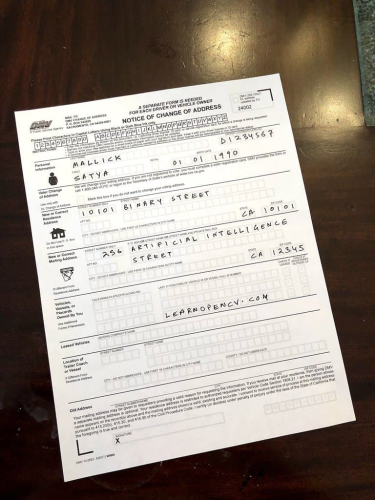

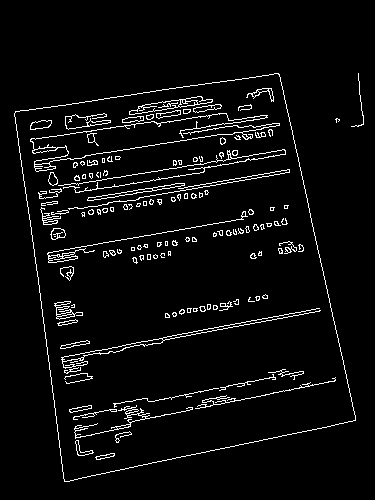

In [6]:
# compute the image to grayscale, blur it, and find edges in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
cv2_imshow(image)
cv2_imshow(edged)

**Step 2: Finding Contours**

STEP 2: Find contours of paper


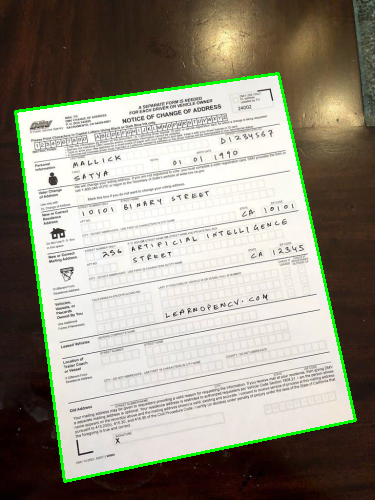

In [7]:
# find the contours in the edged image, keeping only
# the largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
  # approximate the contour
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)

  # if our approximated contour has four points, then we can
  # assume that we have found our screen
  if len(approx) == 4:
    screenCnt = approx
    break

# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(image)

**Step 3: Apply a Perspective Transform & Threshold**

STEP 3: Apply Perspective Transform


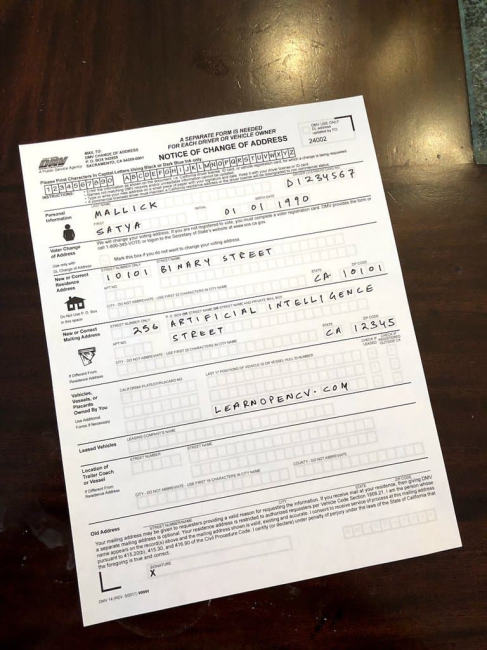

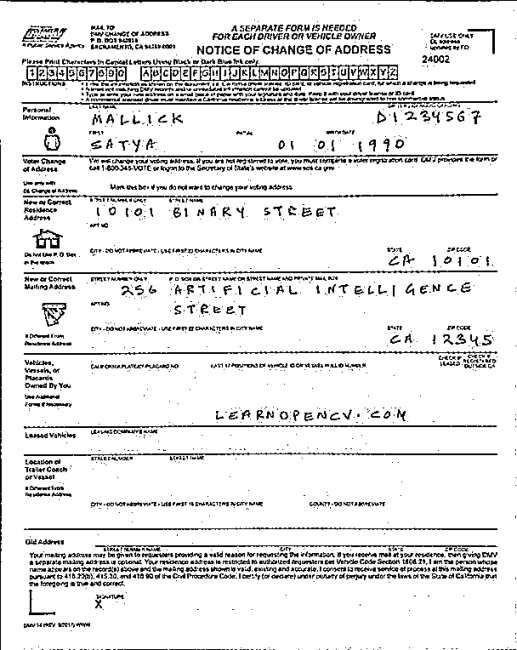

In [8]:
# apply the four point transform to obtain a top-down
# view of the originanl image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

# show the original and scanned images
print("STEP 3: Apply Perspective Transform")
cv2_imshow(imutils.resize(orig, height = 650))
cv2_imshow(imutils.resize(warped, height = 650))

Other examples

STEP 1: Edge Detection


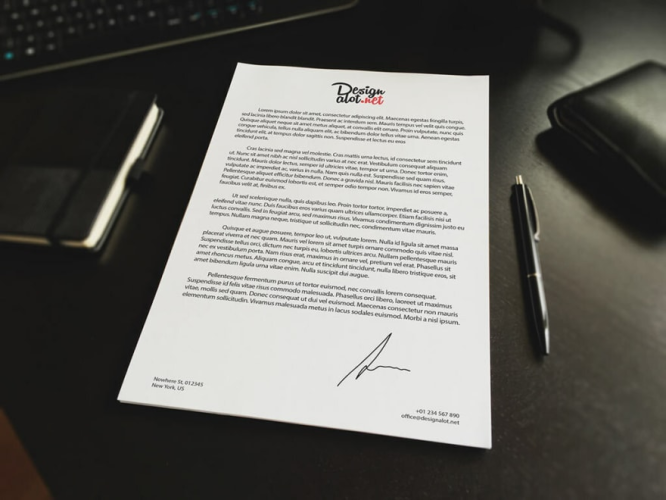

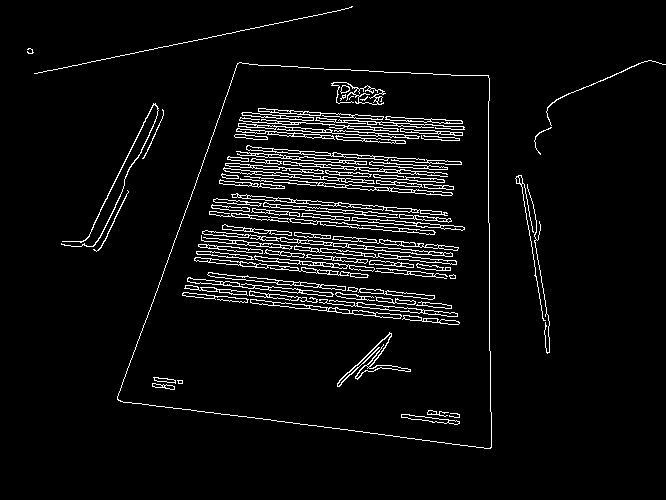




STEP 2: Find contours of paper


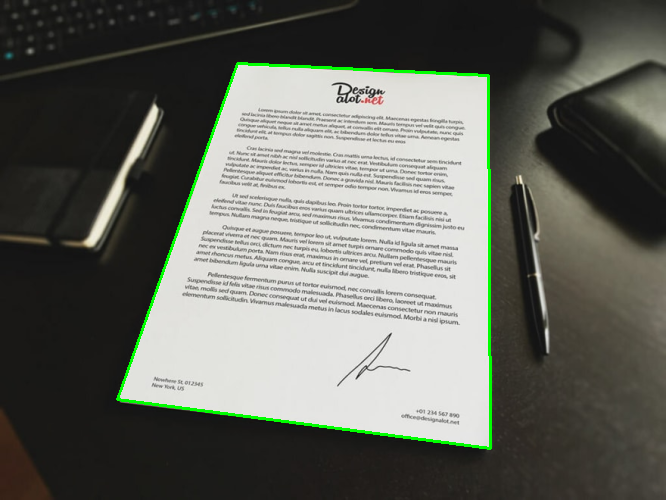




STEP 3: Apply Perspective Transform


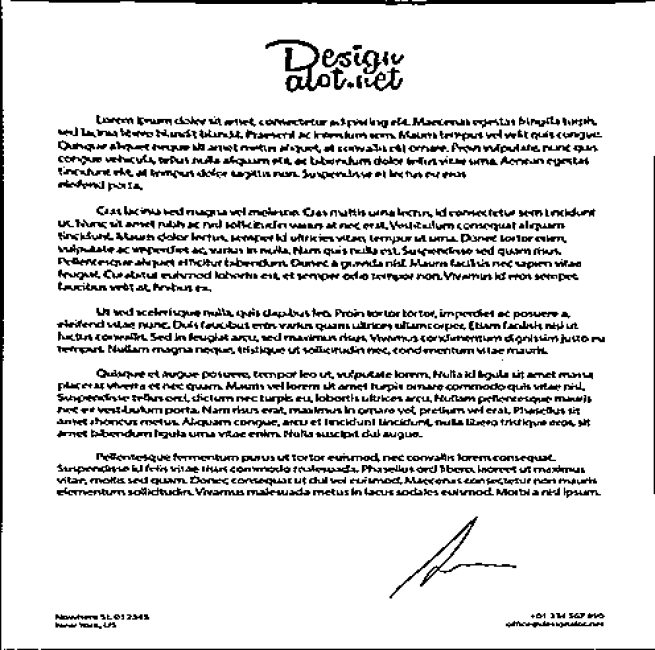

In [9]:
def CamScannerCode(img_file):
  image = cv2.imread(os.path.join(dir, img_file))
  ratio = image.shape[0] / 500.0
  orig = image.copy()
  image = imutils.resize(image, height = 500)

  # compute the image to grayscale, blur it, and find edges in the image
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = cv2.Canny(gray, 75, 200)

  # show the original image and the edge detected image
  print("STEP 1: Edge Detection")
  cv2_imshow(image)
  cv2_imshow(edged)
  print("\n\n")


  # find the contours in the edged image, keeping only
  # the largest ones, and initialize the screen contour
  cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

  # loop over the contours
  for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # if our approximated contour has four points, then we can
    # assume that we have found our screen
    if len(approx) == 4:
      screenCnt = approx
      break

  # show the contour (outline) of the piece of paper
  print("STEP 2: Find contours of paper")
  cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
  cv2_imshow(image)
  print("\n\n")


  # apply the four point transform to obtain a top-down
  # view of the originanl image
  warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

  # convert the warped image to grayscale, then threshold it
  # to give it that 'black and white' paper effect
  warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
  T = threshold_local(warped, 11, offset = 10, method = "gaussian")
  warped = (warped > T).astype("uint8") * 255

  # show the original and scanned images
  print("STEP 3: Apply Perspective Transform")
  cv2_imshow(imutils.resize(warped, height = 650))


# Calling the function
CamScannerCode("doc1.jpg")

STEP 1: Edge Detection


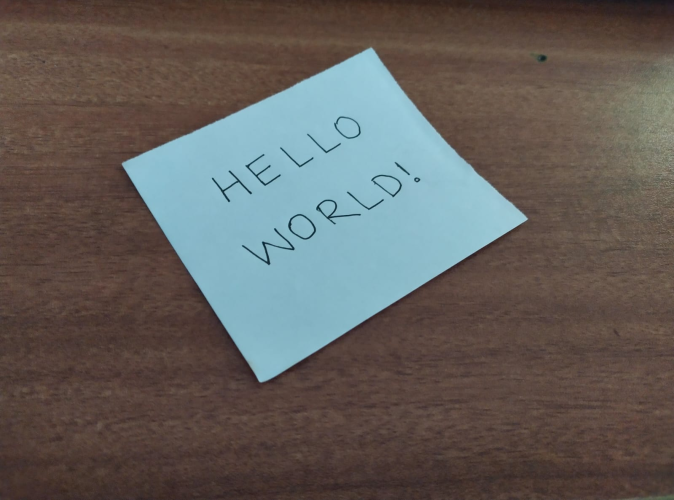

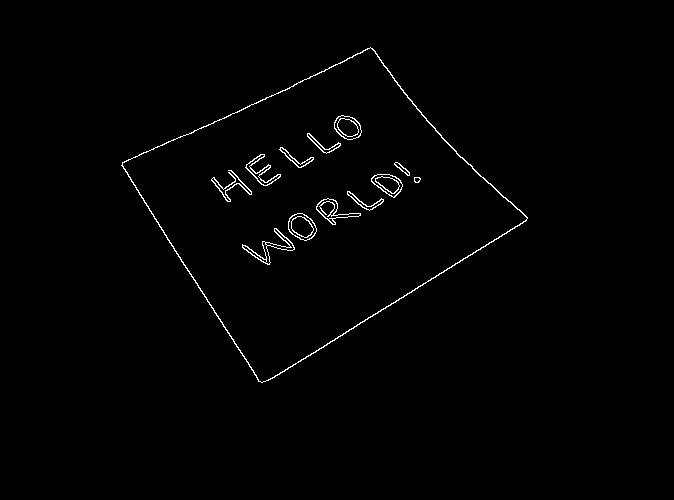




STEP 2: Find contours of paper


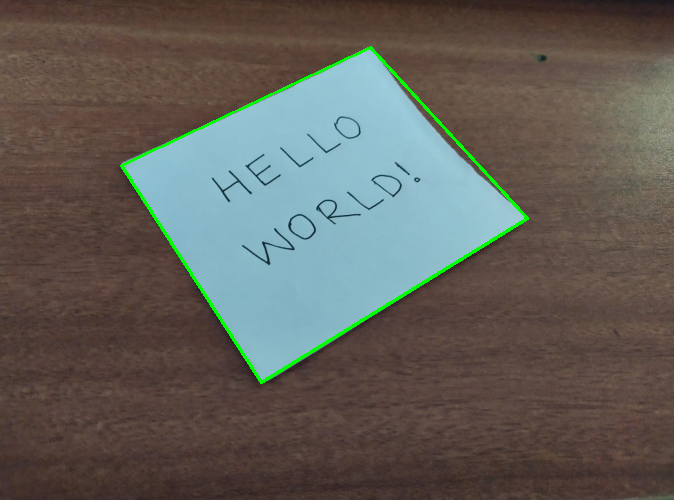




STEP 3: Apply Perspective Transform


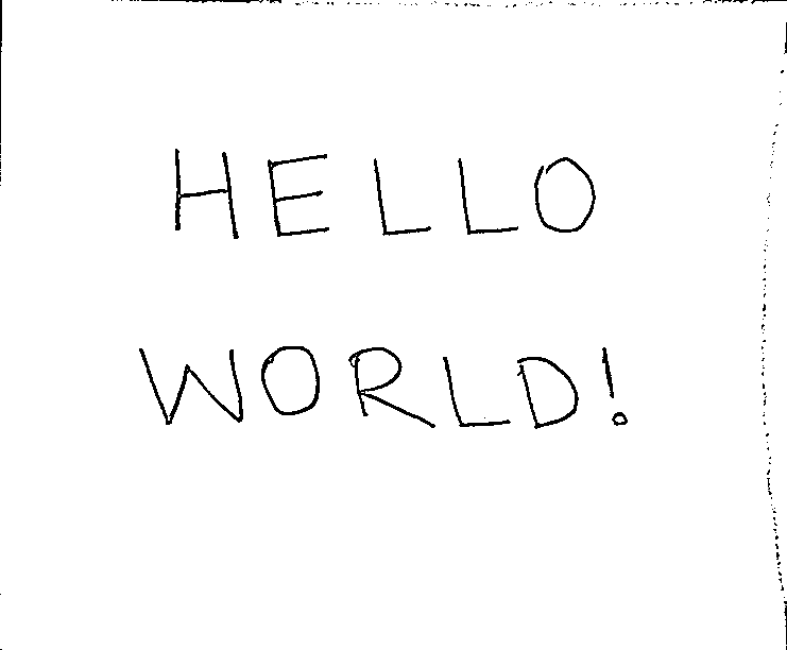

In [10]:
CamScannerCode("doc3.jpg")